In [1]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from random import choice
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 6.0)  # set default size of plots

In [2]:
class RandomApplyTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        transform = choice(self.transforms)
        return transform(img)
    
# transformations for the training data with augmentation
train_transformations1 = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transformations2 = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transformations3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose a random transformation
train_transformations = RandomApplyTransform([train_transformations1, train_transformations2, train_transformations3])

val_test_transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# batch size and number of labels
batch_size = 64
num_labels = 12

# Directory with data
dataset_path = '../data2'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# split data
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
# split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# apply transformations
train_dataset.dataset.transform = train_transformations
val_dataset.dataset.transform = val_test_transformations

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# display sizes
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')


Number of training samples: 1658
Number of validation samples: 415


In [3]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [4]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [5]:
def train(model, optimizer, num_epochs=1):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)

            optimizer.zero_grad()
            scores = model(images)
            loss = loss_fn(scores, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = scores.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        av_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(av_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss = loss_fn(scores, labels)
                val_loss += loss.item()

                _, predicted = scores.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        av_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(av_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {av_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {av_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [6]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = flatten(x)
        x = self.classifier(x)
        return x

In [7]:
# setup model and optimizer
loss_fn = nn.CrossEntropyLoss()

model = AlexNet(num_labels)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [8]:
# train model and get training and validation losses
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, num_epochs=10)
print('Finished Training')

Epoch 1/10, Training Loss: 2.0552, Training Accuracy: 33.17%, Validation Loss: 1.8151, Validation Accuracy: 40.24%
Epoch 2/10, Training Loss: 1.4725, Training Accuracy: 52.17%, Validation Loss: 1.4556, Validation Accuracy: 54.22%
Epoch 3/10, Training Loss: 1.2970, Training Accuracy: 57.72%, Validation Loss: 1.2615, Validation Accuracy: 62.89%
Epoch 4/10, Training Loss: 1.1240, Training Accuracy: 63.33%, Validation Loss: 1.1741, Validation Accuracy: 64.82%
Epoch 5/10, Training Loss: 1.0233, Training Accuracy: 65.98%, Validation Loss: 1.1172, Validation Accuracy: 67.71%
Epoch 6/10, Training Loss: 0.9450, Training Accuracy: 68.46%, Validation Loss: 1.1904, Validation Accuracy: 67.95%
Epoch 7/10, Training Loss: 0.8776, Training Accuracy: 70.99%, Validation Loss: 1.1336, Validation Accuracy: 68.92%
Epoch 8/10, Training Loss: 0.7829, Training Accuracy: 75.03%, Validation Loss: 1.1342, Validation Accuracy: 69.88%
Epoch 9/10, Training Loss: 0.7539, Training Accuracy: 75.57%, Validation Loss: 1

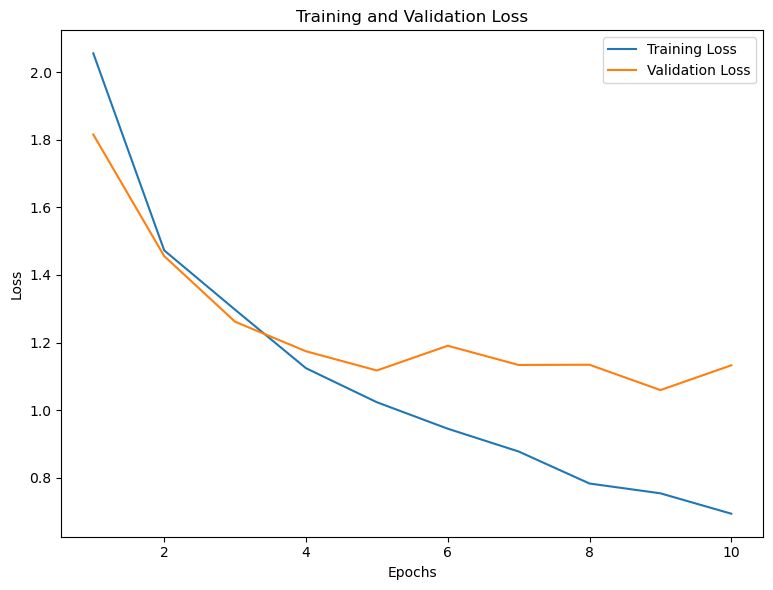

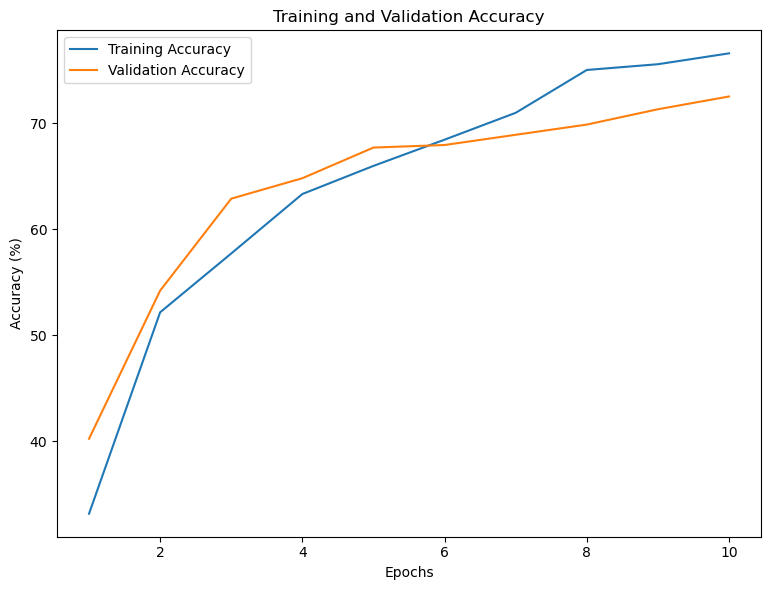

In [9]:
def plots(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot everything to check for overfitting
plots(train_losses, val_losses, train_accuracies, val_accuracies)


In [10]:
print('Validation Set Accuracy')
testVal(val_loader, model)

Validation Set Accuracy
Got 301 / 415 correct (72.53)


In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save("../Checkpoints/AlexNet.pt") # Save the model